In [38]:
import hashlib
import os
import re
from datetime import datetime

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from communities.algorithms import louvain_method

from collections import defaultdict, deque, Counter
from typing import List

#### Message parsing
First, let's define a method to parse the given message file into a list of message dicts containing the information about the message.

In [39]:
def replace_non_ascii(text):
    return re.sub(r'[^\x00-\x7F]+', '?', text)
def parse_chat(file_path: str, is_apple: bool) -> List[dict]:
    pattern = r'^\[(\d{1,2}/\d{1,2}/\d{1,2}), (\d{1,2}:\d{2}:\d{2})\] (.+?): (.*)' if is_apple else r'^(\d{1,2}/\d{1,2}/\d{1,2}), (\d{1,2}:\d{2}) - (.+?): (.*)'

    messages = []
    current_message = None

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            match = re.match(pattern, line)
            if match:
                if current_message:
                    messages.append(current_message)
                date_str, time_str, sender, content = match.groups()
                try:
                    datetime_obj = datetime.strptime(
                        f"{date_str} {time_str}", "%d/%m/%y %H:%M:%S" if is_apple else "%d/%m/%y %H:%M")
                except:
                    datetime_obj = datetime.strptime(
                        f"{date_str} {time_str}", "%m/%d/%y %H:%M:%S" if is_apple else "%m/%d/%y %H:%M")
                current_message = {
                    'datetime': datetime_obj,
                    'sender': replace_non_ascii(sender.strip()),
                    'content': content
                }
            else:
                if current_message and line:
                    current_message['content'] += '\n' + line
        if current_message:
            messages.append(current_message)
    return messages

We can then use such method to obtain a list of all messages. It is also useful to filter the messages by eliminating frokm the list the users with less than 100 sent messages:

In [40]:
FILE_PATH = os.path.join(".", "data", "main.txt")
messages = parse_chat(FILE_PATH, is_apple=True)
print(f"Number of messages: {len(messages)}")

message_counts = Counter([msg['sender'] for msg in messages])
min_messages = 100
messages = [msg for msg in messages if message_counts[msg['sender']] >= min_messages]

year = 2022
start_date = datetime(year, 10, 1)
end_date = datetime(year+1, 10, 1)
messages = [msg for msg in messages if start_date <= msg["datetime"] < end_date]

print(f"Number of messages after the filtering: {len(messages)}")

Number of messages: 105266
Number of messages after the filtering: 25780


Sender names are anonymized to protect user privacy

In [41]:
def anonymize_sender(sender: str) -> str:
    """Generate a consistent anonymized name based on the sender's name."""
    hash_object = hashlib.sha256(sender.encode('utf-8'))
    hash_hex = hash_object.hexdigest()
    return f"User{int(hash_hex, 16) % 10000}"  # Limit to 4-digit user IDs
    
for msg in messages:
    msg['sender'] = anonymize_sender(msg['sender'])

Message senders are displayed in a bar chart based on the number of messages in
the considered timeframe.

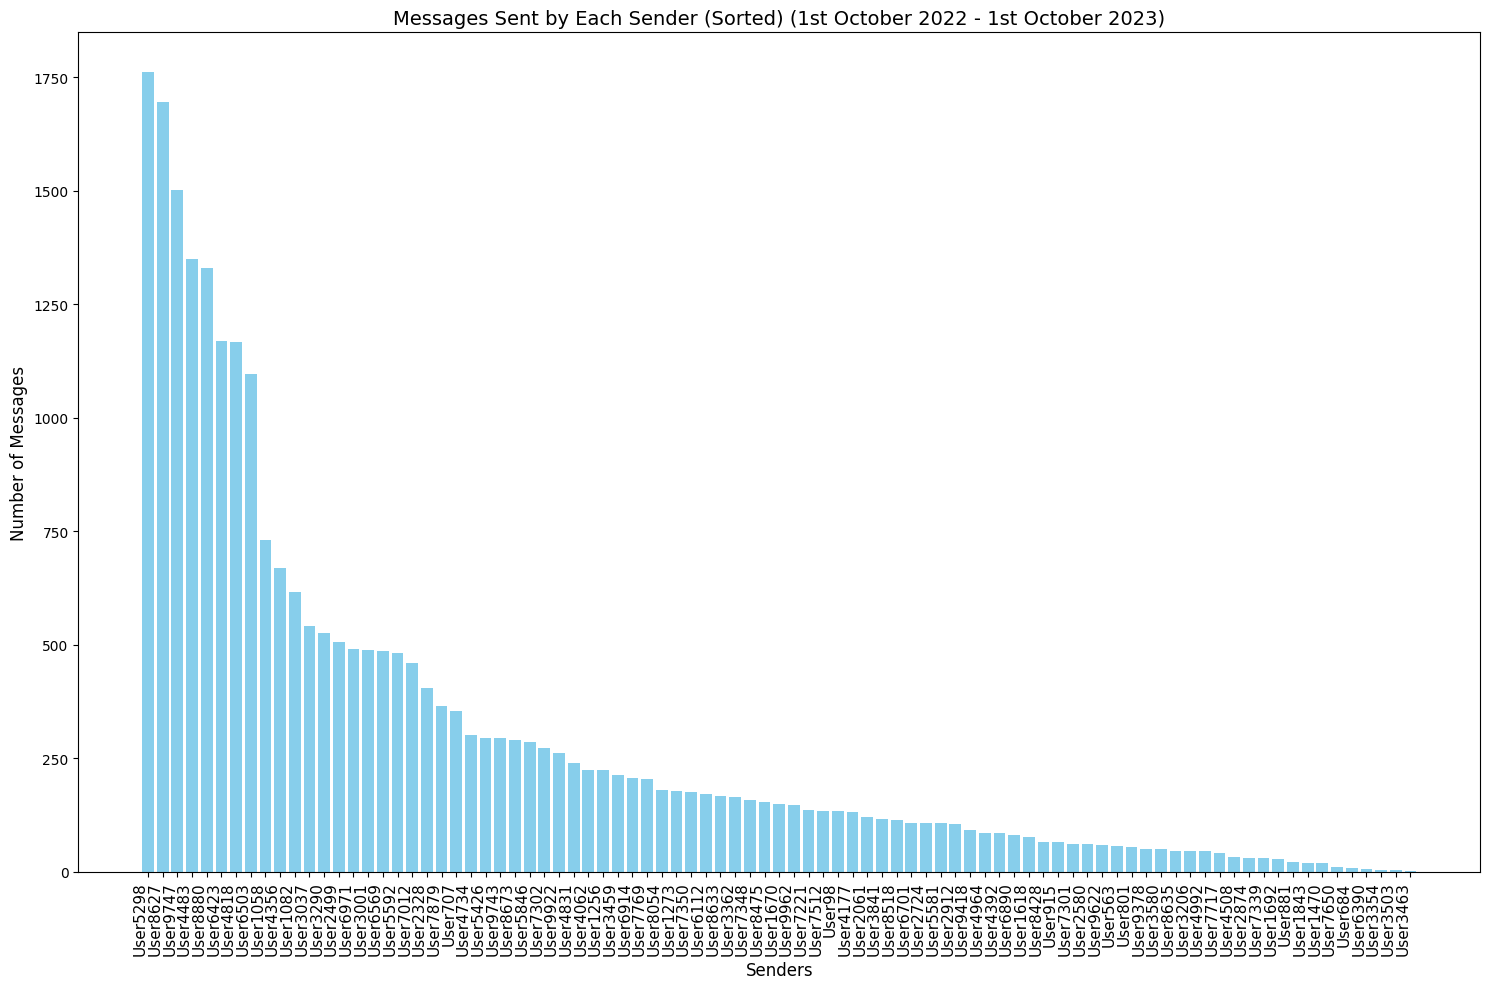

In [42]:
message_counts = Counter([msg['sender'] for msg in messages])
sorted_counts = sorted(message_counts.items(), key=lambda x: x[1], reverse=True)
senders, counts = zip(*sorted_counts)

x_positions = np.arange(len(senders))

plt.figure(figsize=(15, 10))
plt.bar(x_positions, counts, color='skyblue', width=0.8)
plt.xlabel('Senders', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)
plt.title(f'Messages Sent by Each Sender (Sorted) (1st October {year} - 1st October {year+1})', fontsize=14)
plt.xticks(ticks=x_positions, labels=senders, rotation=90, ha='right', fontsize=11)
plt.tight_layout()
plt.show()

#### Building the message-reponse graph.

Now, we can write a method to identify the edges of the graph, meaning the message-reponse couples inside the messages list.

At the moment, the heuristics used to identify message-response couples is the number of seconds between one message and the other.

The method takes a lot of time to finish running, so a progress percentage is displayed. Also, a double-ended queue is used to create a window inside which to compare messages with the previous ones (insted of comparing a message with every message before it). 

In [43]:
def build_reply_network(messages: List[dict], time_threshold=300) -> dict:
    edges = defaultdict(int)
    messages = sorted(messages, key=lambda m: m['datetime'])

    window = deque()
    total = len(messages)

    for i, current_msg in enumerate(messages):
        current_time = current_msg['datetime']
        replier = current_msg['sender']

        # Remove from the queue messages that are too old
        while window and (current_time - window[0]['datetime']).total_seconds() > time_threshold:
            window.popleft()

        progress = (i / total) * 100
        print(f"\rProgress: {progress:.2f}%", end='', flush=True)

        # Compare with messages in the window 
        for prev_msg in window:
            author = prev_msg['sender']
            if replier != author:
                edges[(replier, author)] += 1

        window.append(current_msg)

    print("\nDone.")
    return edges

reply_network = build_reply_network(messages, time_threshold=20)
print(f"Number of message-reply couples: {len(reply_network)}")

Progress: 100.00%
Done.
Number of message-reply couples: 1894


#### Analyzing the graph

Now, we can define a method to calculate relevant metrics on the given message-reponse graph.

Each node in the graph is a person and each person is linked to the people with whom he chatted the most, based on the messae-reponse graph.

Each link is weighted proportionally to the number of messages sent to the other person.

In [44]:
def analyze_graph(edges: dict):
    G = nx.DiGraph()
    for (source, target), weight in edges.items():
        G.add_edge(source, target, weight=weight)

    # Centrality measures
    closeness = nx.closeness_centrality(G)
    betweenness = nx.betweenness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
    pagerank = nx.pagerank(G)
    degree = dict(G.degree())

    # Community detection
    partition, _ = louvain_method(nx.to_numpy_array(G.to_undirected()))

    # Most popular (in-degree)
    in_degree = dict(G.in_degree())
    most_popular = max(in_degree.items(), key=lambda x: x[1])[0]

    return {
        'graph': G,
        'closeness': closeness,
        'betweenness': betweenness,
        'eigenvector': eigenvector,
        'pagerank': pagerank,
        'degree': degree,
        'communities': partition,
        'most_popular': most_popular
    }
graph_analysis = analyze_graph(reply_network)

#### Visualizing centrality mesaures and community size

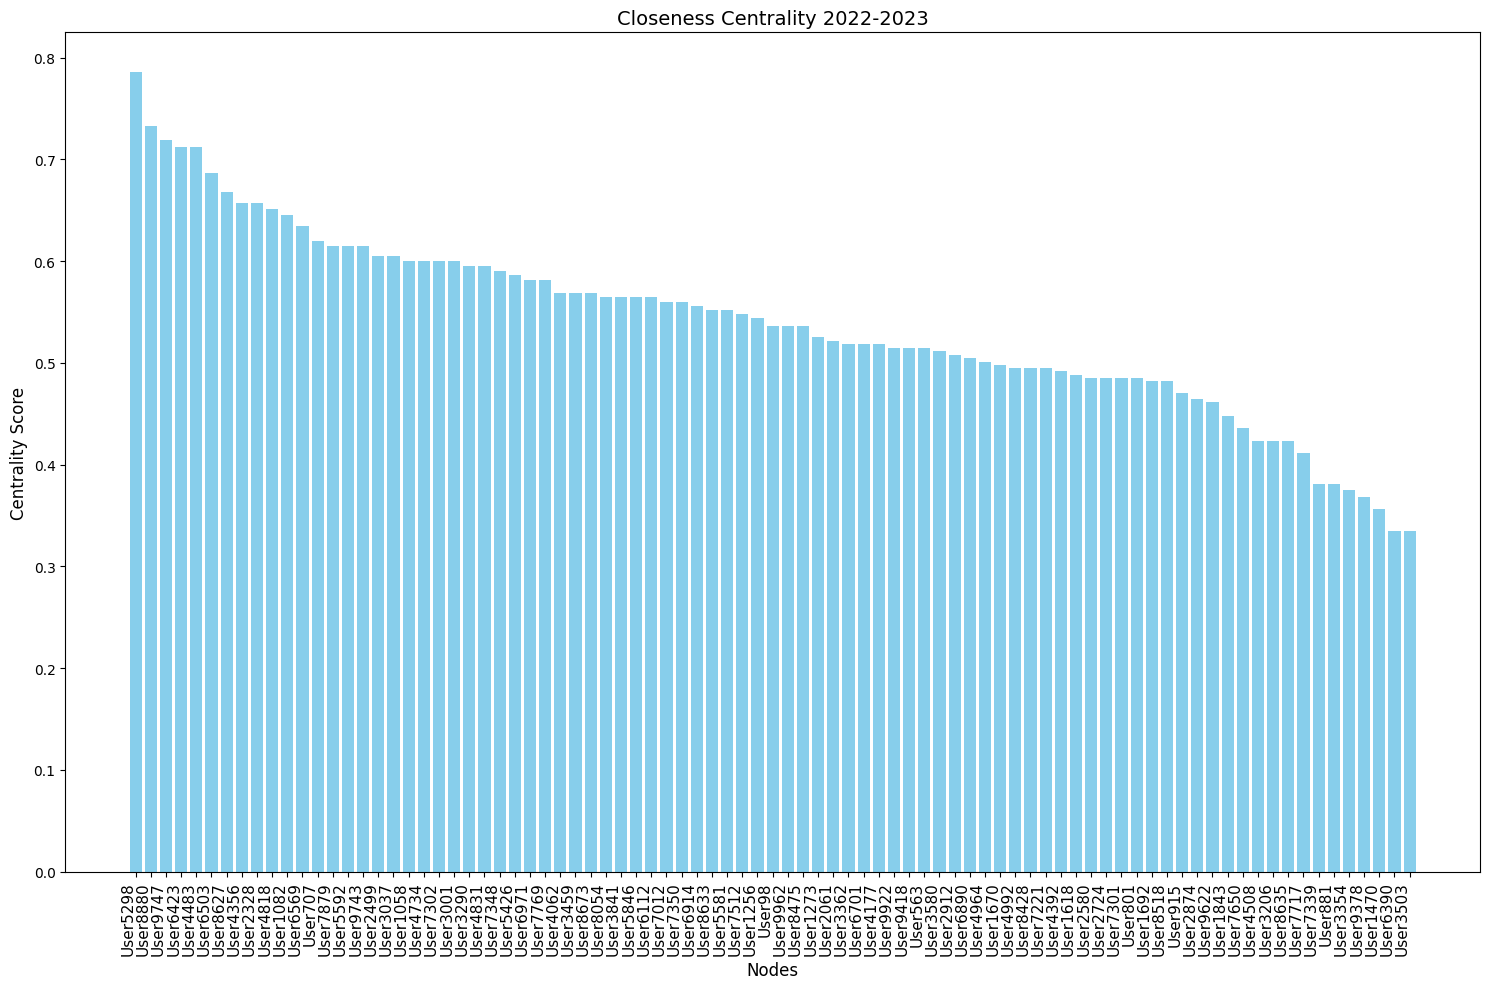

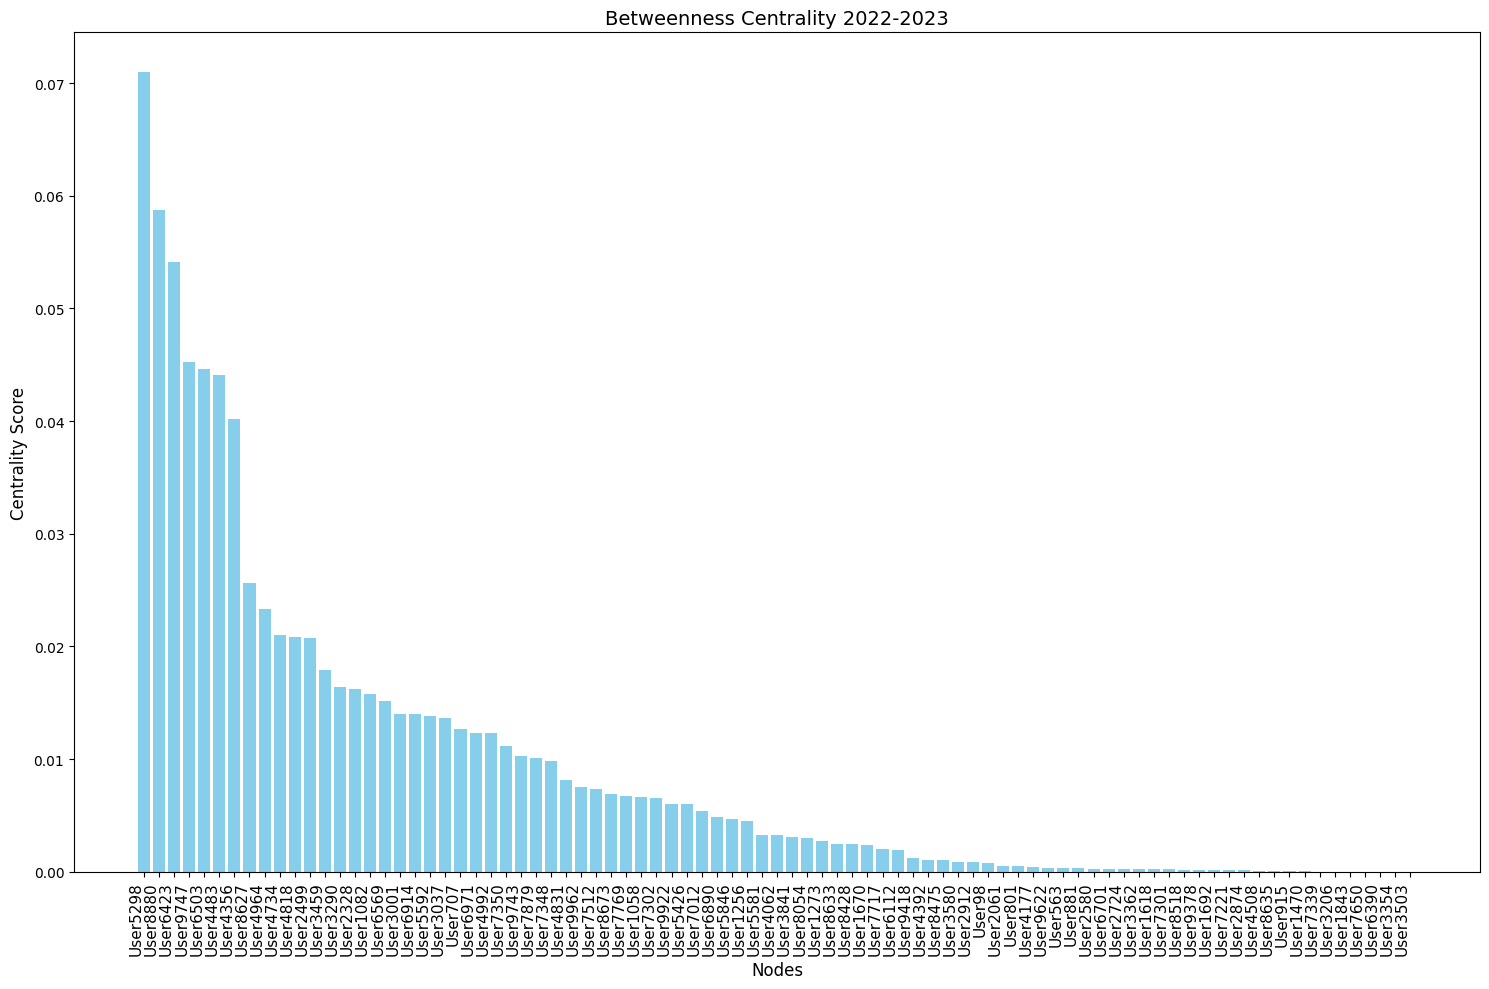

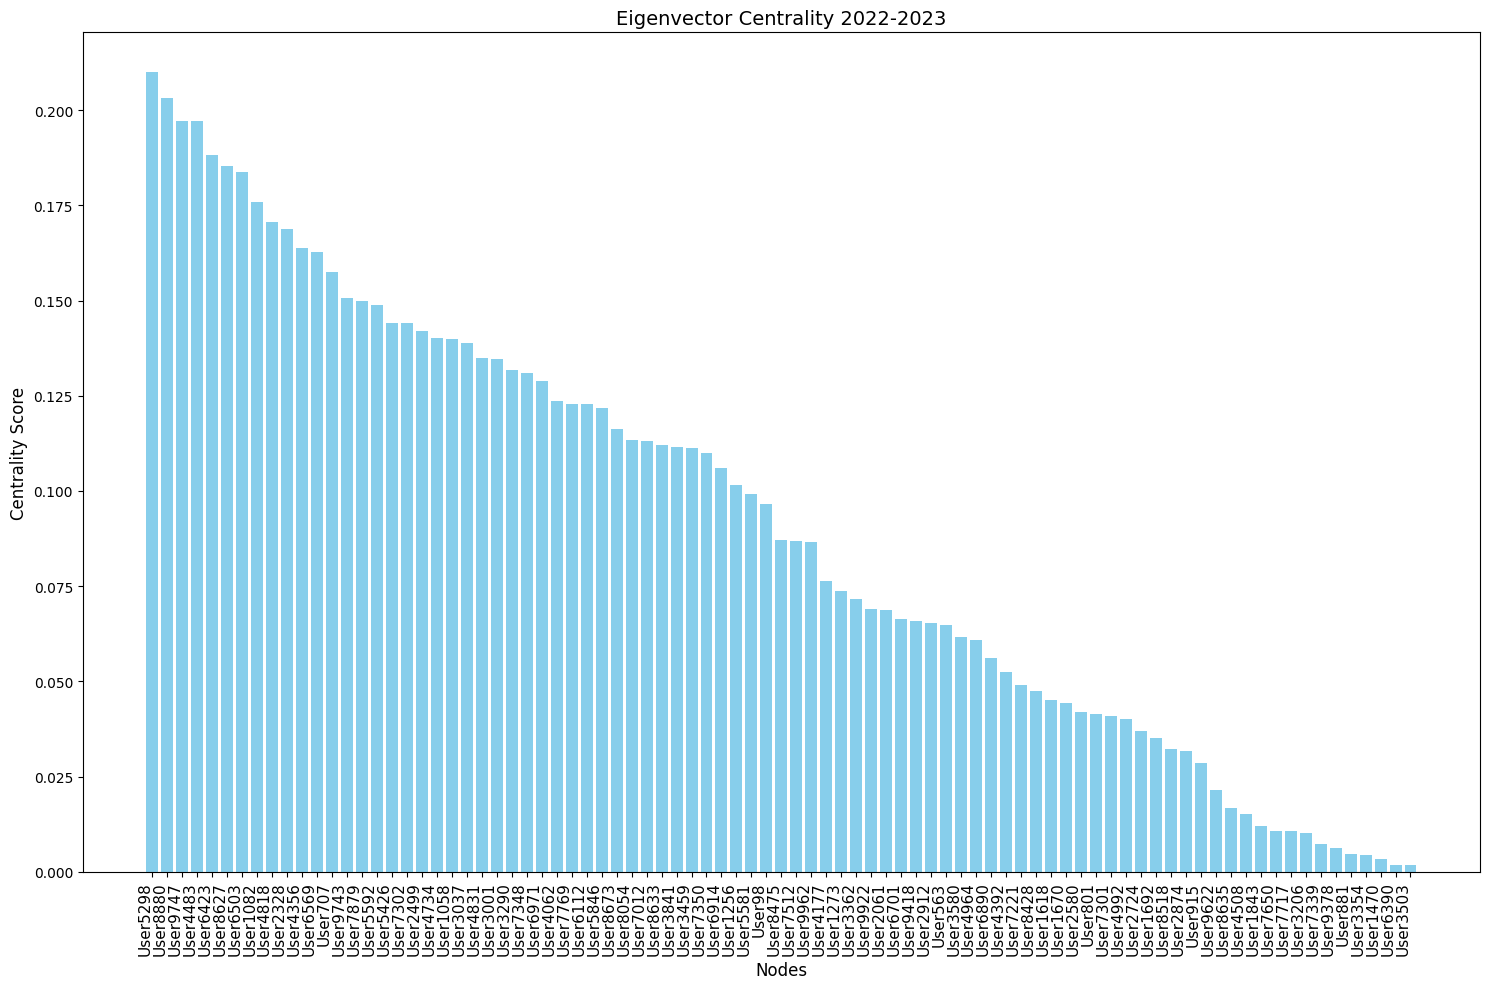

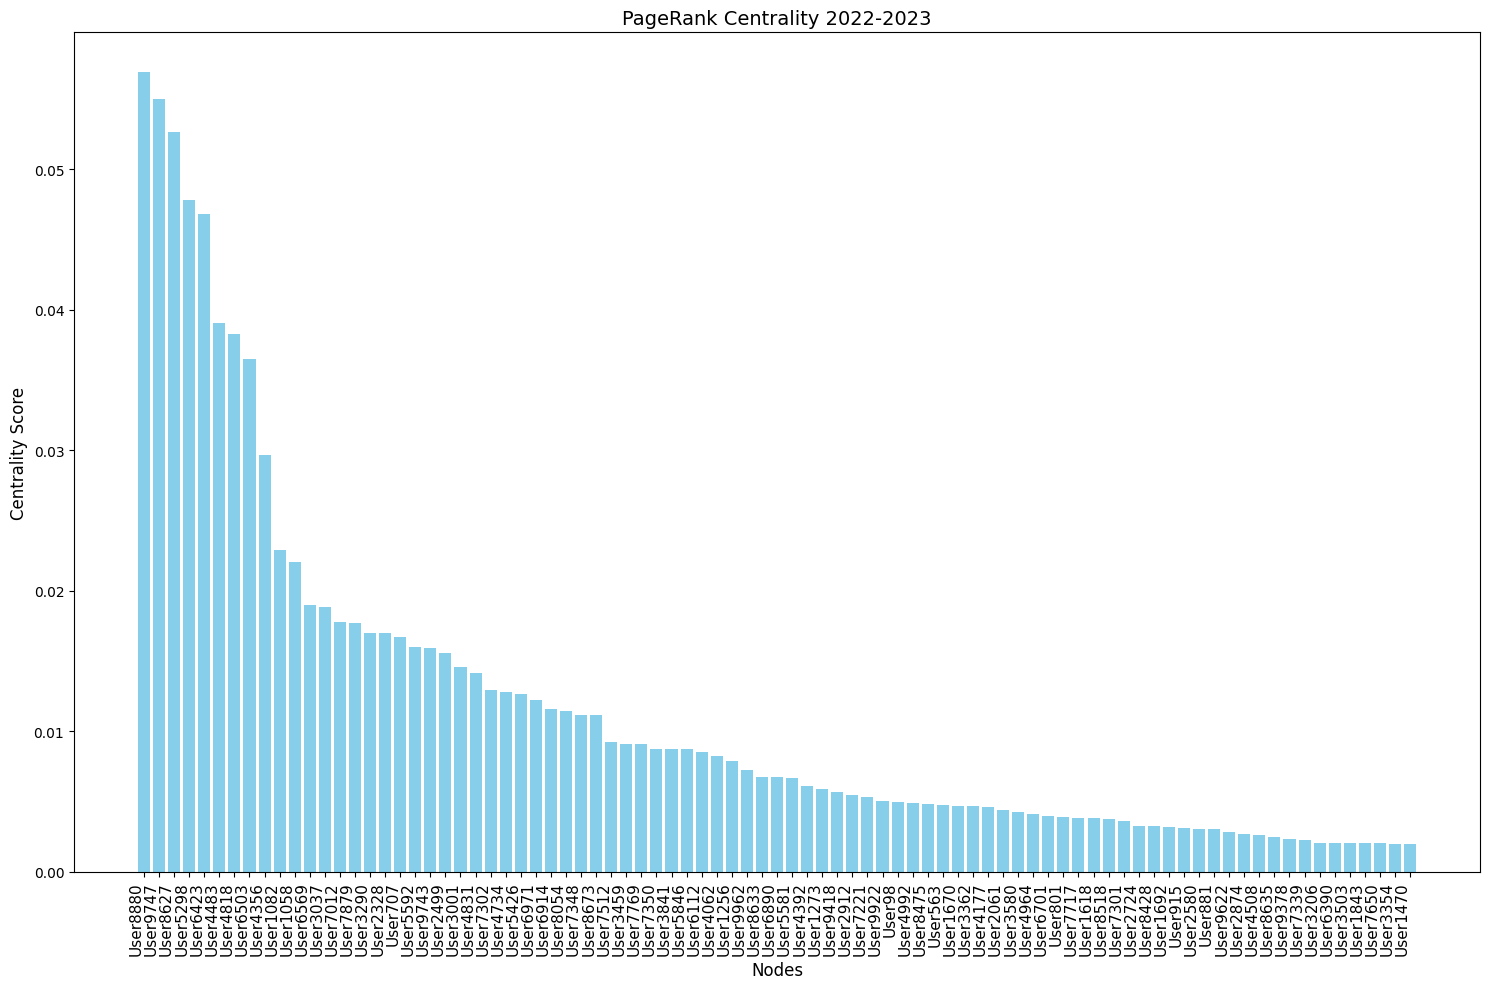

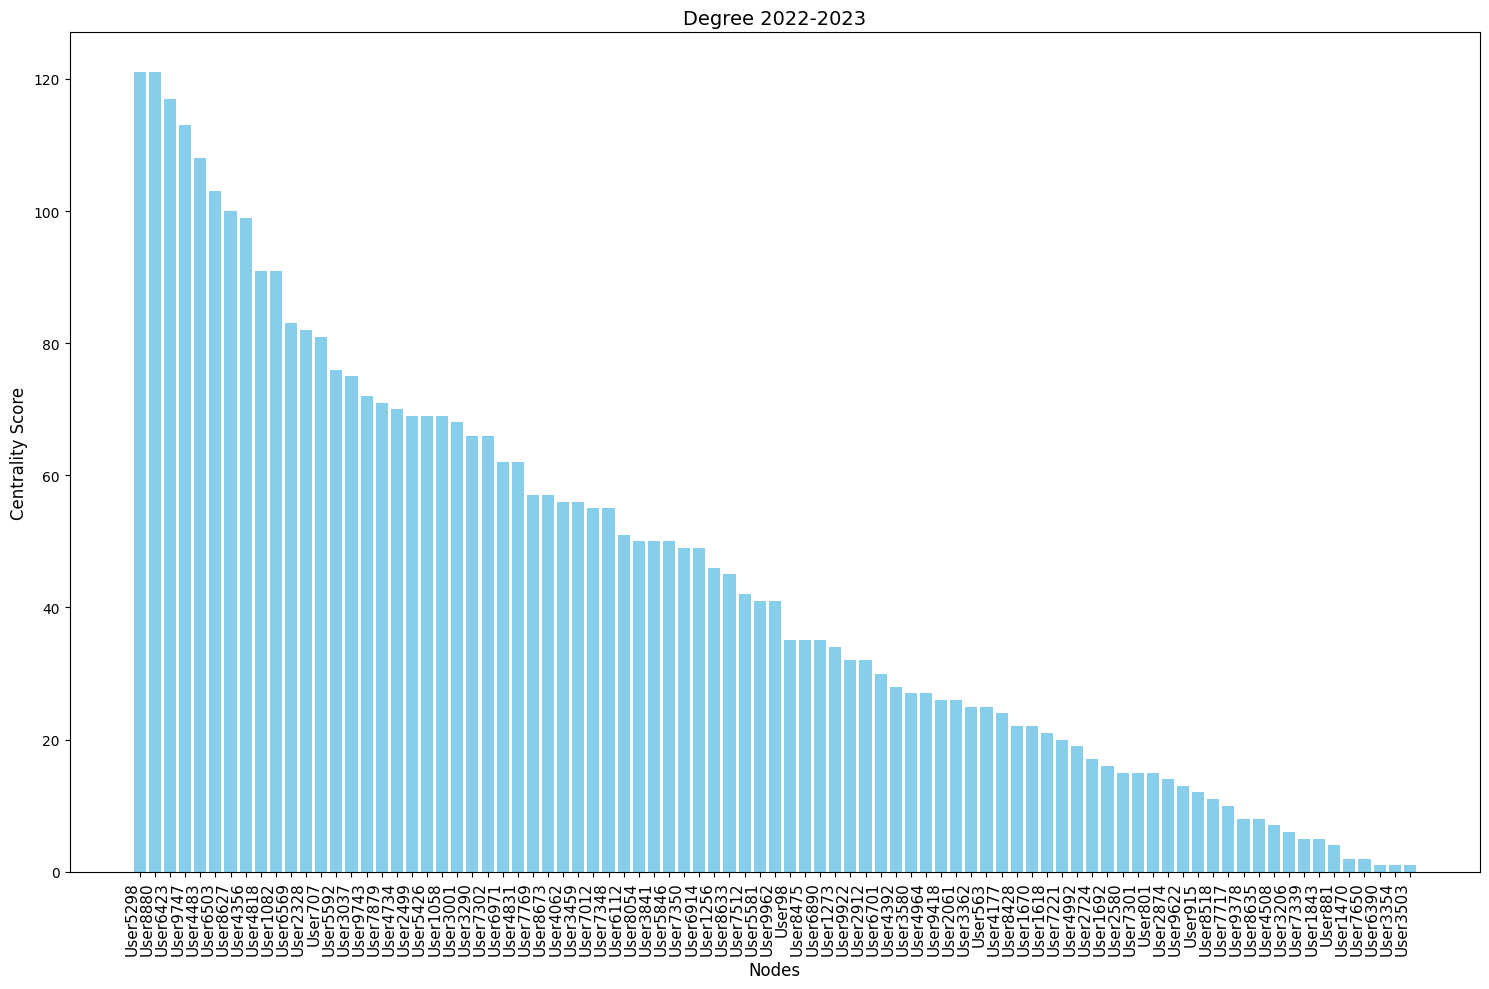

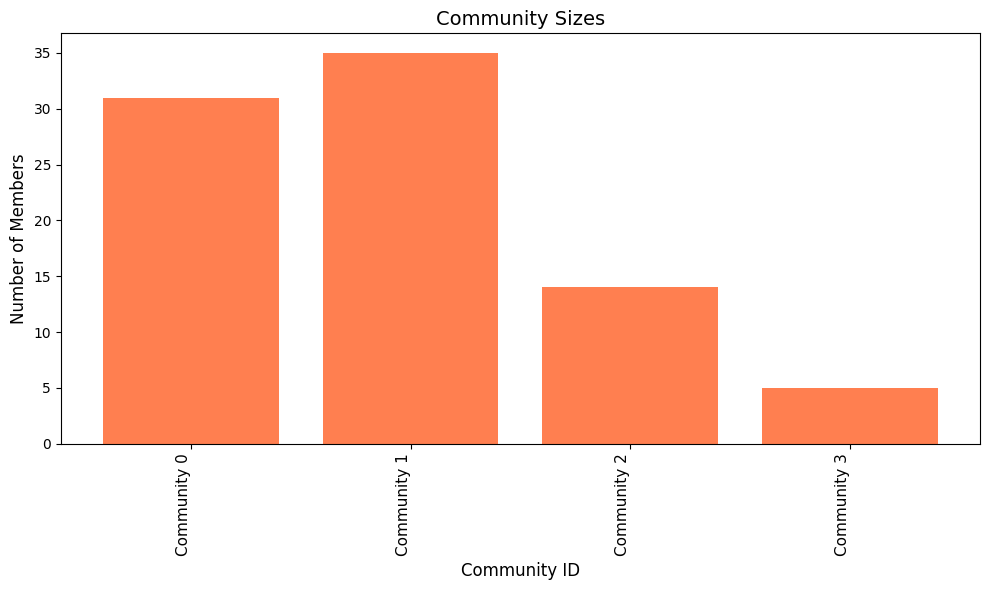

In [45]:
centrality_measures = {
    "Closeness Centrality": graph_analysis['closeness'],
    f"Betweenness Centrality": graph_analysis['betweenness'],
    f"Eigenvector Centrality": graph_analysis['eigenvector'],
    f"PageRank Centrality": graph_analysis['pagerank'],
    f"Degree": graph_analysis['degree']
}

for measure_name, centrality_dict in centrality_measures.items():
    sorted_centrality = sorted(centrality_dict.items(), key=lambda x: -x[1])
    nodes, scores = zip(*sorted_centrality)
    
    # Plot the bar chart
    plt.figure(figsize=(15, 10))
    plt.bar(nodes, scores, color='skyblue')
    plt.xlabel('Nodes', fontsize=12)
    plt.ylabel('Centrality Score', fontsize=12)
    plt.title(f'{measure_name} {year}-{year+1}', fontsize=14)
    plt.xticks(rotation=90, ha='right', fontsize=11)
    plt.tight_layout()
    plt.show()

# Plot communities
communities = graph_analysis['communities']
community_sizes = [len(community) for community in communities]

plt.figure(figsize=(10, 6))
plt.bar(range(len(communities)), community_sizes, color='coral')
plt.xlabel('Community ID', fontsize=12)
plt.ylabel('Number of Members', fontsize=12)
plt.title('Community Sizes', fontsize=14)
plt.xticks(range(len(communities)), [f'Community {i}' for i in range(len(communities))], rotation=90, ha='right', fontsize=11)
plt.tight_layout()
plt.show()

#### Visualizing the graph

Here's the graph with all nodes and arcs:

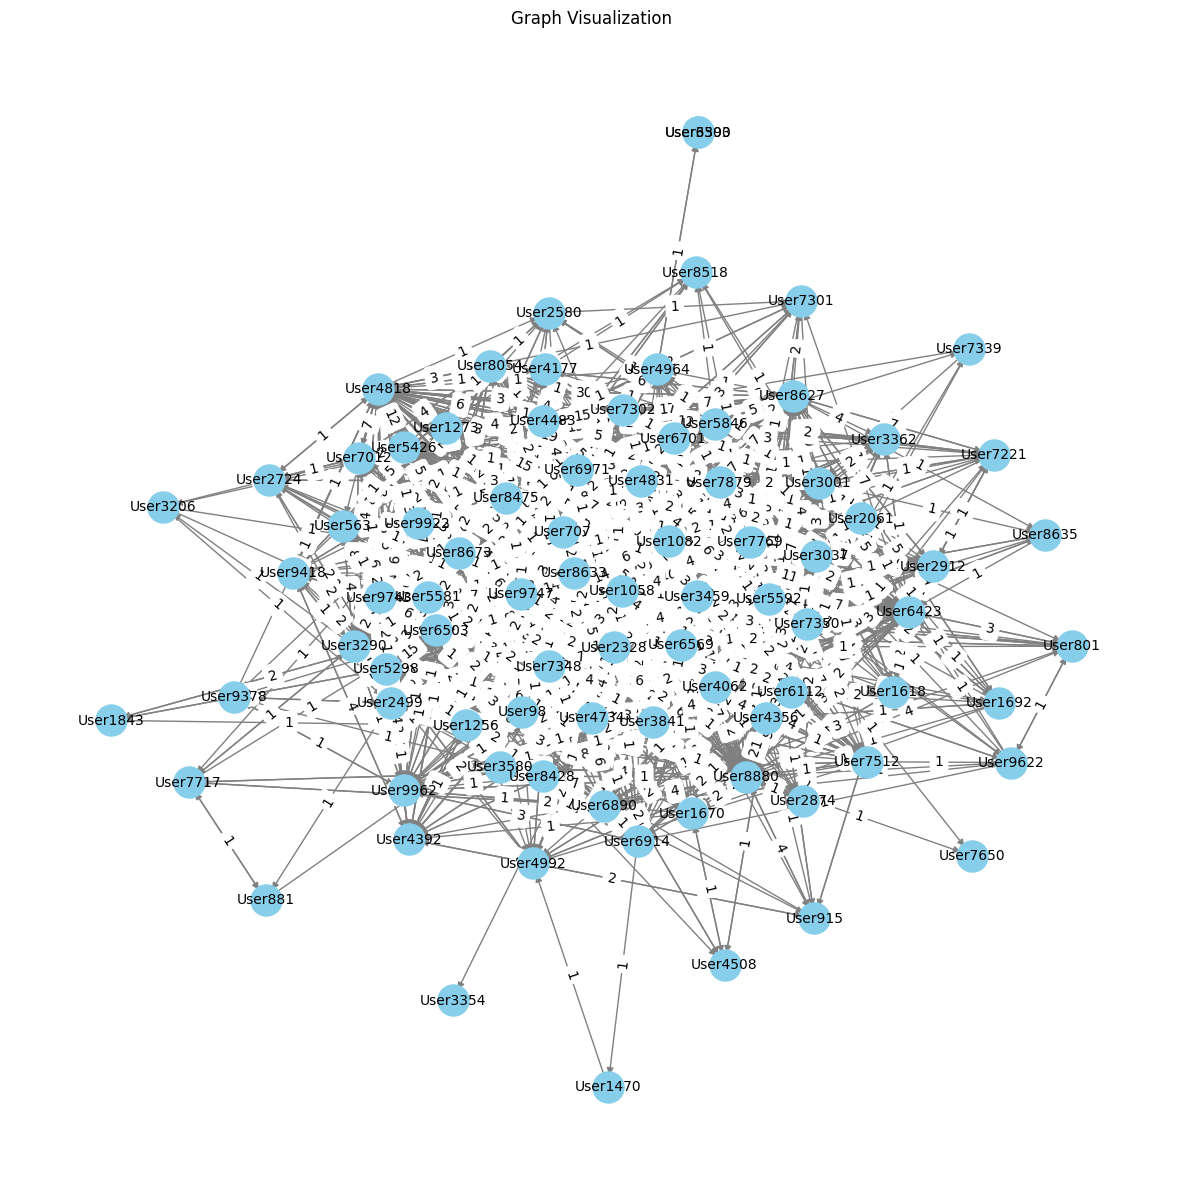

In [46]:
G = graph_analysis["graph"]

pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)
nx.draw_networkx_labels(G, pos, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Graph Visualization")
plt.axis('off')
plt.show()

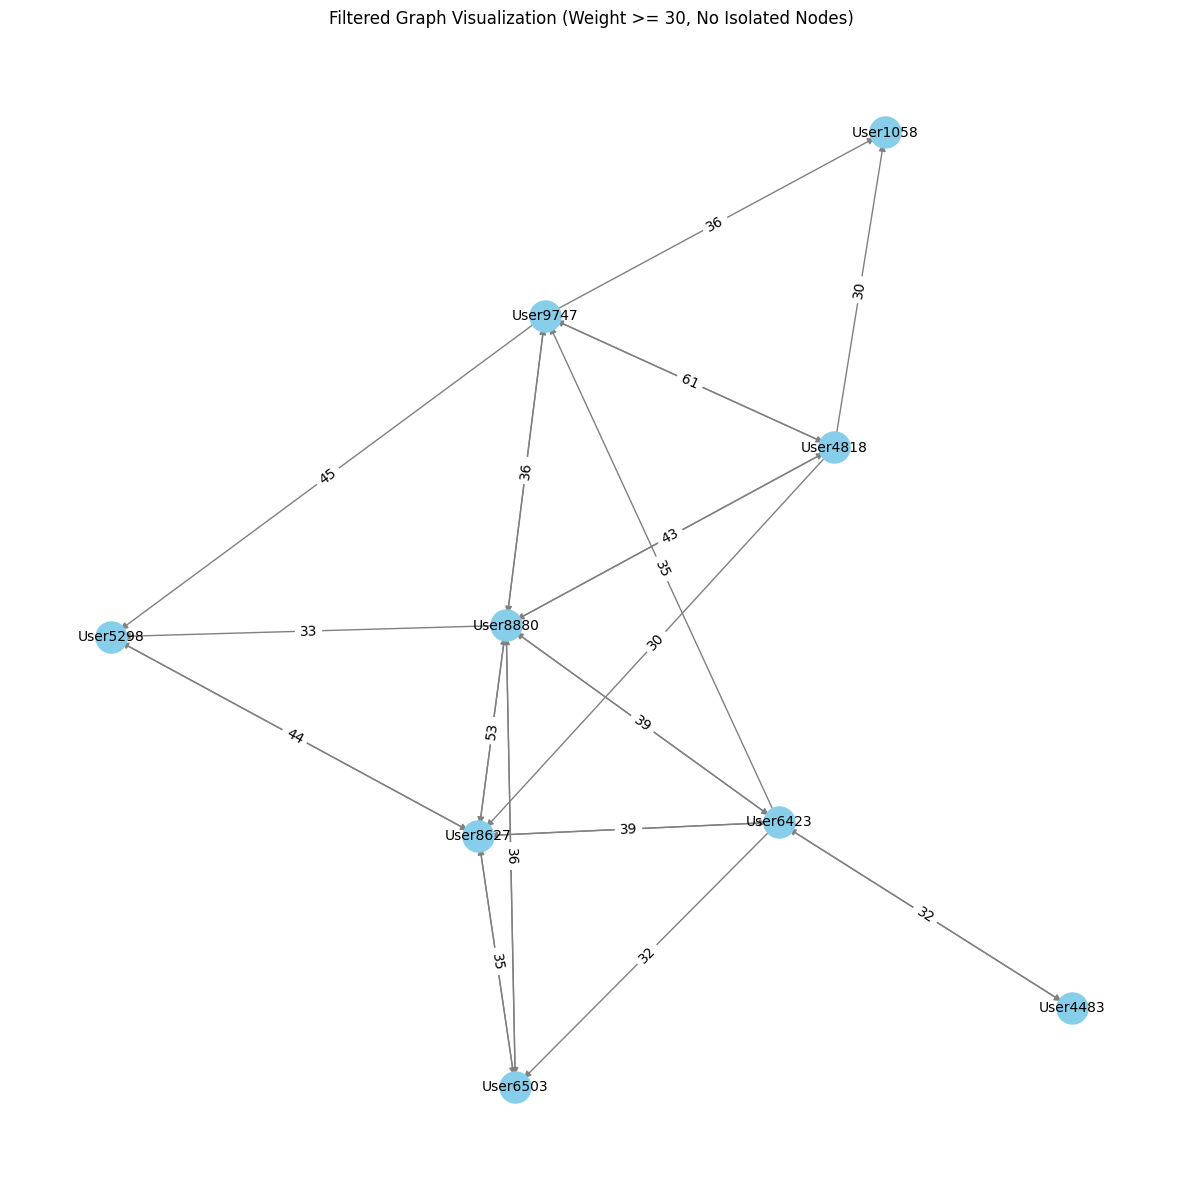

In [50]:
filtered_G = G.copy()

# Remove arcs with less than a given weight
min_weight = 30
for u, v, data in list(filtered_G.edges(data=True)):
    if data.get('weight', 0) < min_weight:
        filtered_G.remove_edge(u, v)

# Remove nodes with no links
isolated_nodes = list(nx.isolates(filtered_G))
filtered_G.remove_nodes_from(isolated_nodes)

pos = nx.kamada_kawai_layout(filtered_G)
plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(filtered_G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(filtered_G, pos, edge_color='gray', arrows=True)
nx.draw_networkx_labels(filtered_G, pos, font_size=10)
edge_labels = nx.get_edge_attributes(filtered_G, 'weight')
nx.draw_networkx_edge_labels(filtered_G, pos, edge_labels=edge_labels)

plt.title(f"Filtered Graph Visualization (Weight >= {min_weight}, No Isolated Nodes)")
plt.axis('off')
plt.show()

In [48]:
print("Most Popular Person:", graph_analysis['most_popular'])

# --- Communities ---
senders = list(set(msg['sender'] for msg in messages))
sender_to_node = {sender: idx for idx, sender in enumerate(senders)}
node_to_sender = {idx: sender for sender, idx in sender_to_node.items()}

# Print communities using sender names
print("\nCommunities:")
community_map = defaultdict(list)
for id, members in enumerate(graph_analysis["communities"]):
    community_map[id] = list(members)

for comm_id, members in sorted(community_map.items()):
    sender_names = [node_to_sender.get(node, f"Unknown({node})") for node in sorted(members)]
    print(f"Community {comm_id} ({len(members)} members):")
    print(" ", ", ".join(sender_names))
    print()

# --- Centrality Measures ---
top_n = 20

# Helper to get top N from a centrality dict
def get_top_centrality(centrality_dict):
    return sorted(centrality_dict.items(), key=lambda x: -x[1])[:top_n]

# Get top N for each centrality
closeness_top = get_top_centrality(graph_analysis['closeness'])
betweenness_top = get_top_centrality(graph_analysis['betweenness'])
eigenvector_top = get_top_centrality(graph_analysis['eigenvector'])
pagerank_top = get_top_centrality(graph_analysis['pagerank'])

# Print top 20 for each
print(f"\nTop {top_n} Closeness Centrality:")
for person, score in closeness_top:
    print(f"{person}: {score:.3f}")

print(f"\nTop {top_n} Betweenness Centrality:")
for person, score in betweenness_top:
    print(f"{person}: {score:.3f}")

print(f"\nTop {top_n} Eigenvector Centrality:")
for person, score in eigenvector_top:
    print(f"{person}: {score:.3f}")

print(f"\nTop {top_n} PageRank Centrality:")
for person, score in pagerank_top:
    print(f"{person}: {score:.3f}")

# --- Compare and Find Differences ---
closeness_set = {p for p, _ in closeness_top}
betweenness_set = {p for p, _ in betweenness_top}
eigenvector_set = {p for p, _ in eigenvector_top}
pagerank_set = {p for p, _ in pagerank_top}

print("\n--- Differences Between Centrality Measures ---")

all_names = closeness_set | betweenness_set | eigenvector_set | pagerank_set

for name in sorted(all_names):
    in_measures = []
    if name in closeness_set: in_measures.append("Closeness")
    if name in betweenness_set: in_measures.append("Betweenness")
    if name in eigenvector_set: in_measures.append("Eigenvector")
    if name in pagerank_set: in_measures.append("PageRank")

    if len(in_measures) < 4:
        print(f"{name} appears in: {', '.join(in_measures)}")


Most Popular Person: User5298

Communities:
Community 0 (31 members):
  User4508, User2328, User9962, User7350, User4992, User7348, User7650, User2874, User7769, User4356, User8054, User8880, User3503, User3290, User7302, User7717, User881, User4483, User3001, User8673, User5581, User3463, User4392, User8518, User4734, User1082, User6423, User8627, User7339, User707, User9922

Community 1 (35 members):
  User9418, User3580, User801, User6390, User6701, User9747, User9743, User4818, User7879, User7301, User8633, User915, User6112, User6914, User8635, User9622, User5426, User7221, User4062, User7512, User3362, User4964, User5298, User2061, User3459, User3841, User6890, User2724, User1618, User1470, User2580, User8475, User4831, User1058, User684

Community 2 (14 members):
  User6569, User2912, User1273, User563, User5592, User7012, User1843, User6971, User4177, User3354, User2499, User1256, User1692, User8428

Community 3 (5 members):
  User9378, User5846, User1670, User3206, User3037


